In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_distribution, plot_bloch_multivector, array_to_latex, plot_histogram
from qiskit.extensions import Initialize, UnitaryGate
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.result import marginal_counts
from qiskit import quantum_info
from qiskit.circuit import Parameter

In [2]:
# Preparación de estado inicial
psi = Statevector(random_statevector(2))
psi.draw('latex')

<IPython.core.display.Latex object>

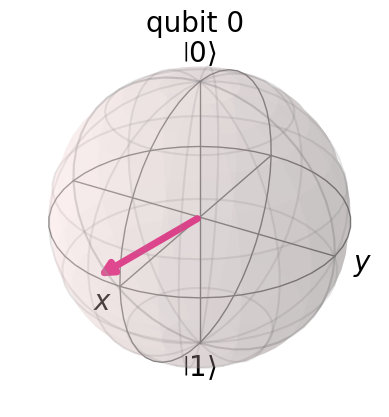

In [3]:
plot_bloch_multivector(psi)

In [4]:
# Función que genera circuito de teleportación con estados Werner
def crear_estado_werner(circuito, qubit1, qubit2, parameter):
    #Define simbólicamente el parámetro del estado mezclado
    #theta = Parameter('theta')
    
    #Define el generador de números aleatorios con una ponderación de w
    circuito.ry(parameter, 1)
    circuito.cx(1, 3)
    
    #Genera estado máximamente mezclado
    circuito.h(1)
    
    circuito.x(3)
    circuito.ch(3, 2)
    circuito.ccx(1,3,4)
    circuito.ccx(2,3,5)
    
    #Genera estado entrelazado
    circuito.x(3)
    circuito.cx(3,2)
    circuito.ccx(1,3,2)
    circuito.x(3)
    
    #Define el valor del parámetro theta y por ende, se define el peso w
    #bc = circuito.bind_parameters({theta: parameter})
    
def alice_operaciones(circuito, qubit0, qubit1):
    circuito.cx(qubit0, qubit1)
    circuito.h(qubit0)

def medir_luego_enviar(circuito, qubit0, qubit1, bit1, bit2):
    circuito.measure(qubit0, bit1)
    circuito.measure(qubit1, bit2)
    
def bob_operaciones(circuito, qubits, bit1, bit2, bell):
    circuito.x(qubits[2]).c_if(bit2, not int(bell[1])) #El bit2 es resultado de medir q1
    circuito.z(qubits[2]).c_if(bit1, not int(bell[0])) #El bit1 es resultado de medir q0
    #Se aplicarán las puertas X ó Z en función del estado de Bell utilizado
    
def teleportation(psi, w):
    theta = 2*np.arcsin(w)
    q0_init_transform = Initialize(psi)
    q2_reverse_transform = q0_init_transform.gates_to_uncompute()
    qubits = QuantumRegister(6, name="q")    # Registramos 6 qúbits de nombre "q"
    
    cbit1 = ClassicalRegister(1, name="cbit0") # Primer bit clásico 
    cbit2 = ClassicalRegister(1, name="cbit1") # Segundo bit clásico
    cbit3 = ClassicalRegister(1, name="cbit2") # Segundo bit clásico
   
    circuito = QuantumCircuit(qubits, cbit1, cbit2, cbit3)

    #Inicializamos el qúbit de Alice:
    circuito.append(q0_init_transform, [0]) #agrega la instrucción "q0_init_transform" al final del circuito 
    circuito.barrier()
    
    #El Telamon crea un par de Bell
    crear_estado_werner(circuito, qubits[1], qubits[2], theta)
    circuito.barrier()
    
    #Alice realiza operaciones con sus qubits
    alice_operaciones(circuito, qubits[0], qubits[1])
    #circuito.save_statevector()
    
    #Alice mide sus qúbits y envía por whatsapp a Bob
    medir_luego_enviar(circuito, qubits[0], qubits[1], cbit1, cbit2)
    circuito.barrier()
    
    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, qubits, cbit1, cbit2, "11")
    circuito.append(q2_reverse_transform, [2])
    circuito.measure(2, cbit3)
    return [circuito, qubits]

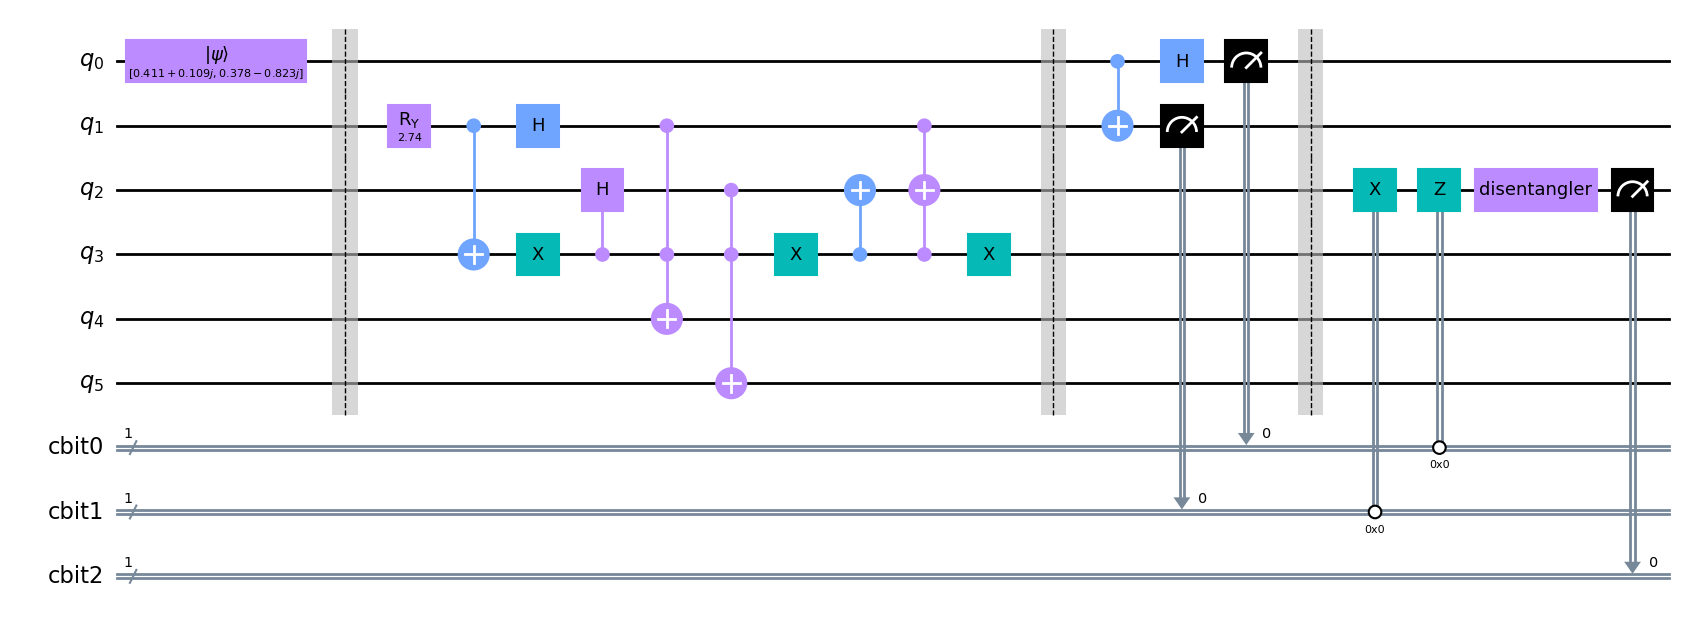

In [5]:
qc, qubits = teleportation(psi, w=0.98)

qc.draw(output="mpl")

In [6]:
sim = Aer.get_backend("aer_simulator") 
output = execute(qc, sim)
counts = output.result().get_counts(qc)

In [7]:
qubit_counts = [marginal_counts(counts, [bit]) for bit in range(3)]

Text(0.5, 0, 'Classical State')

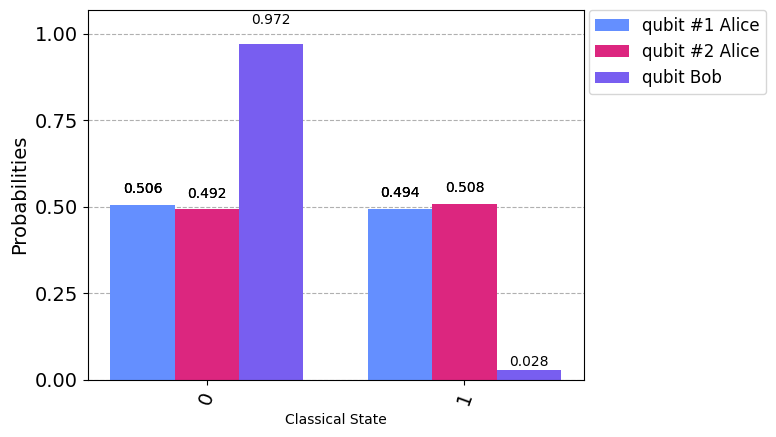

In [8]:
import matplotlib.pyplot as plt
grafica = plt.subplot()
legendas = ["qubit #1 Alice","qubit #2 Alice","qubit Bob"]
plot_distribution(qubit_counts, ax=grafica, legend=legendas)
grafica.set_ylabel('Probabilities')
grafica.set_xlabel('Classical State')

In [9]:
image = qc.draw(output="mpl")

In [10]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Convierte la imagen a un objeto de bytes
buf = BytesIO()
image.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
im = Image.open(buf)

# Convierte la imagen a formato RGB
im = im.convert('RGB')

# Guarda la imagen en formato PDF
im.save('circuito.pdf', 'PDF', resolution=100.0)